## Preparación del entorno

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
conda install python-graphviz

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done


# All requested packages already installed.



In [34]:
conda install graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Clasificación en árboles de decisión

Los árboles de decisión (decision trees) también permiten la clasificación y la regresión, se basan en grafos con estructura de árboles. Los árboles de decisión son modelos del tipo denominado de “caja blanca”, son intuitivos y fáciles de interpretar y entran dentro de la denominada Inteligencia Artificial explicable, por contra los resultados obtenidos de un modelo de “caja negra” hay que admitirlos per se, no son explicables.

## Entrenar y visualizar árboles de decisión

Para entender los árboles de decisión, vamos a construir uno para ver cómo hace las predicciones.

Vamos a ver cómo visualizar los árboles usando los datos de flores iris ya comentados en KNN pero usando las medidas de los pétalos en lugar de la de los sépalos.

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

Podemos visualizar el árbol de decisión usando primero el método export_graphviz() para producir un archivo de definicion gráfico llamado iris_tree.dot

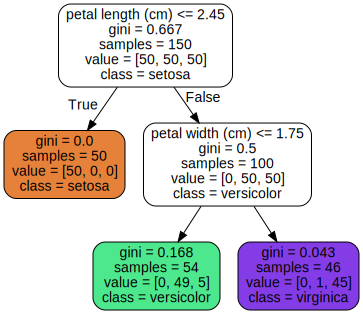

In [7]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

## Hacer predicciones

Imaginemos que encontramos una flor iris y queremos clasificarla. 

- Empezamos por el nodo raíz (profundidad 0, arriba): este nodo pregunta si la longitud del pétalo de la flor es inferior a 2,45 cm. 
    - Si lo es , bajamos al nodo hijo de la izquierda (profundidad 1, izquierda). En este caso, se trata de un "nodo terminal" (es decir, no tiene nodos hijo), así que no formula ninguna pregunta: simplemente mira la clase predicha par ese nodo y veremos que el árbol de decisión predice que la flor es una Iris setosa (class = setosa).

Ahora imaginemos que nos encontramos otra flor y, esta vez, la longitud del pétalo es mayor que 2,45 cm. 

- Tenemos que bajar por el nodo hijo de la derecha (profundidad 1, derecha), que como no es un nodo terminal, hace otra pregunta: 
    - ¿es la anchiura del pétalo menor que 1,75 cm? 
           - Si lo es, es muy probable que la flor sea un Iris versicolor (profundidad 2, izquierda). 
           - Si no lo es, seguramente sea un Iris virginica (profundidad 2, derecha).

#### Nota
Una de las múltiples cualidades de los árboles de decisión es que requieren muy poca preparación de los datos. De hecho, no requieren escalado de características ni centrado.

- El atributo ``samples`` de un nodo cuenta a cuántas instancias de entrenamiento se aplica. Por ejemplo,100 instancias de entrenamiento tienen una longitud de pétalo de más de 2,45 cm (profundidad 1, derecha) y, de esas 100, 54 tienen una anchura de pétalo de menos de 1,75 cm (profundidad 2, izquierda). 

- El atributo ``value`` de un nodo indica a cuántas instancias de entrenamiento de cada clase se aplica el nodo: por ejemplo, el nodo de abajo a la dercha se aplica a 0 Iris setosa, 1 Iris versicolor y 45 Iris virginica. 

- Por último, el atributo ``gini`` de un nodo mide su impureza: un nodo es "puro" (gini=0) si todas las instancias de entrenamiento a las que se aplica pertenecen a la misma clase. Por ejemplo, dado que el nodo de profundidad 1 solo se aplica a instancias de entranmiento Iris setosa, es puro y su puntuación ```gini = 0```. 

La siguiente ecuación muestra como el algoritmo de entrenamiento computa la puntuación ```gini```$G_i$ del $i_º$ nodo. El nodo izquierdo de profundidad 2 tiene una puntuación ```gini``` igual a $1- (0/54)^2 - (49/54)^2 - (5/54)^2 \approx 0,168$

\begin{equation*}
G_i = 1 - \sum_{k=1}^n P_i,k^2
\end{equation*}

En esta ecuación:

- $P_i,k$ es el ratio de instancias de clase ```k``` entre las instancias de entrenamiento del $i_º$ nodo.

#### Nota
Scikit-learn utiliza el algoritmo CART que solo produce árboles binarios, sin embargo hay otros algoritmos como los ID3 que pueden producir árboles de decisión con nodos que tengan más de dos hijos.

La siguiente imagen nos muestra los límites de decisión de este árbol.

- La línea gruesa representa el límite de decisión del nodo raíz (profundidad 0): longitud de pétalo = 2,45 cm.

- Como el área de la izquierda es pura (solo Iris setosa), ya no puede divirise más.

- En cambio el área de la derecha es impura, así que el nodo derecho de profundidad 1 se divide en anchura de pétalo = 1,75 cm (representado por la línea de guiones). 

- Dado que max_depth era 2, el árbol de decisión se tiene justo ahí. Si configuramos max_depth = 3, los dos nodos de profundidad 2 añadirían cada uno otro límite de decisión (representado por las líneas de puntos).

Saving figure decision_tree_decision_boundaries_plot


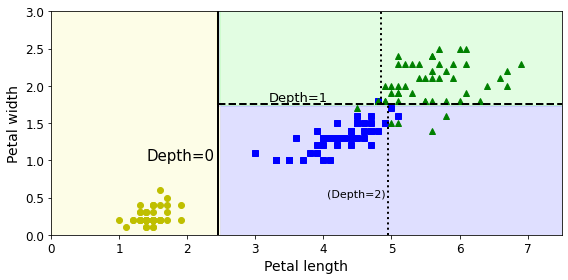

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

## Ventajas VS Desventajas

Algunas ventajas de los árboles de decisión son:

- Sencillo de entender e interpretar. Los árboles se pueden visualizar.

- Requiere poca preparación de datos. Otras técnicas a menudo requieren la normalización de datos, es necesario crear variables ficticias y eliminar valores en blanco. Sin embargo, tenga en cuenta que este módulo no admite valores perdidos.

- El costo de usar el árbol (es decir, predecir datos) es logarítmico en el número de puntos de datos usados para entrenar el árbol.

- Capaz de manejar datos tanto numéricos como categóricos. Otras técnicas suelen estar especializadas en analizar conjuntos de datos que tienen un solo tipo de variable.

- Capaz de manejar problemas de múltiples salidas.

- Utiliza un modelo de caja blanca. Si una situación dada es observable en un modelo, la explicación de la condición se explica fácilmente mediante lógica booleana. Por el contrario, en un modelo de caja negra (por ejemplo, en una red neuronal artificial), los resultados pueden ser más difíciles de interpretar.

- Posible validar un modelo mediante pruebas estadísticas. Eso permite tener en cuenta la fiabilidad del modelo.

- Se desempeña bien incluso si el modelo real a partir del cual se generaron los datos viola sus suposiciones.

Las desventajas de los árboles de decisión incluyen:

- Los aprendices de árboles de decisiones pueden crear árboles demasiado complejos que no generalizan bien los datos. Esto se llama sobreajuste. Para evitar este problema son necesarios mecanismos como la poda, el establecimiento del número mínimo de muestras necesarias en un nodo de la hoja o el establecimiento de la profundidad máxima del árbol.

- Los árboles de decisión pueden ser inestables porque pequeñas variaciones en los datos pueden resultar en la generación de un árbol completamente diferente. Este problema se mitiga mediante el uso de árboles de decisión dentro de un conjunto.

- Se sabe que el problema de aprender un árbol de decisión óptimo es NP-completo en varios aspectos de la optimalidad e incluso para conceptos simples. En consecuencia, los algoritmos prácticos de aprendizaje del árbol de decisiones se basan en algoritmos heurísticos, como el algoritmo codicioso, donde se toman decisiones localmente óptimas en cada nodo. Dichos algoritmos no pueden garantizar la devolución del árbol de decisiones globalmente óptimo. Esto se puede mitigar entrenando varios árboles en un aprendiz de conjunto, donde las características y muestras se muestrean al azar con reemplazo.

- Hay conceptos que son difíciles de aprender porque los árboles de decisión no los expresan fácilmente, como XOR, problemas de paridad o multiplexor.

- Los aprendices del árbol de decisiones crean árboles sesgados si dominan algunas clases. Por lo tanto, se recomienda equilibrar el conjunto de datos antes de ajustarlo al árbol de decisiones.

## Consejos de uso práctico
- Los árboles de decisión tienden a sobreajustarse a los datos con una gran cantidad de características. Es importante obtener la proporción correcta de muestras con respecto al número de características, ya que es muy probable que un árbol con pocas muestras en un espacio de gran dimensión se sobreajuste.

- Considere realizar la reducción de dimensionalidad ( PCA , ICA o selección de características ) de antemano para darle a su árbol una mejor oportunidad de encontrar características que sean discriminatorias.

- Comprender la estructura del árbol de decisiones ayudará a obtener más información sobre cómo el árbol de decisiones hace predicciones, lo cual es importante para comprender las características importantes de los datos.

- Visualice su árbol mientras entrena utilizando la export función. Use max_depth=3 como una profundidad de árbol inicial para tener una idea de cómo el árbol se ajusta a sus datos y luego aumente la profundidad.

- Recuerde que la cantidad de muestras necesarias para poblar el árbol se duplica por cada nivel adicional al que crece el árbol. Use max_depth para controlar el tamaño del árbol para evitar el sobreajuste.

- Utilice min_samples_splito min_samples_leaf para asegurarse de que varias muestras informan cada decisión en el árbol, controlando qué divisiones se considerarán. Un número muy pequeño generalmente significará que el árbol se ajustará en exceso, mientras que un número grande evitará que el árbol aprenda los datos. Pruébelo min_samples_leaf=5 como valor inicial. Si el tamaño de la muestra varía mucho, se puede utilizar un número flotante como porcentaje en estos dos parámetros. Si bien min_samples_split puede crear hojas arbitrariamente pequeñas, min_samples_leaf garantiza que cada hoja tenga un tamaño mínimo, evitando nodos de hojas de baja varianza y sobreajuste en problemas de regresión. Para la clasificación con pocas clases, min_samples_leaf=1 suele ser la mejor opción.

- Equilibre su conjunto de datos antes del entrenamiento para evitar que el árbol esté sesgado hacia las clases dominantes. El balance de clases se puede hacer muestreando un número igual de muestras de cada clase, o preferiblemente normalizando la suma de los pesos de las muestras ( sample_weight) para cada clase al mismo valor. También tenga en cuenta que los criterios de prepoda basados en el peso, como min_weight_fraction_leaf, estarán menos sesgados hacia las clases dominantes que los criterios que no son conscientes de los pesos de la muestra, como min_samples_leaf.

- Si se pesan las muestras, será más fácil optimizar la estructura del árbol utilizando un criterio de poda previa basado en el peso, como min_weight_fraction_leaf, que asegura que los nudos de las hojas contienen al menos una fracción de la suma total de los pesos de las muestras.

- Todos los árboles de decisión utilizan np.float32 matrices internamente. Si los datos de entrenamiento no están en este formato, se realizará una copia del conjunto de datos.

- Si la matriz de entrada X es muy escasa, se recomienda convertirla a escasa csc_matrix antes de llamar a ajuste y escasa csr_matrix antes de llamar a predecir. El tiempo de entrenamiento puede ser varios órdenes de magnitud más rápido para una entrada de matriz escasa en comparación con una matriz densa cuando las entidades tienen valores cero en la mayoría de las muestras.

### Intepretación del modelo: caja blanca vs caja negra
Los árboles de decisión son intuitivos y sus decisiones son fáciles de interpretar. Tales modelos se denominan modelos de caja blanca. En cambio, hay otros como los random forest o redes neuronales que se consideran por regla general de caja negra, es decir son difíciles de explicar en términos sencillos el por qué se han hecho las predicciones.

## Estimación de probabilidades de clase

Un árbol de decisión también puede estimar la probabilidad de que una instancia pertenezca a una clase k particular. Primero recorre el árbol para encontrar el nodo terminal para esta instancia y luego devuelve el ratio de instancias de entrenamiento de clase k en este nodo.

Por ejemplo, aplicado a este caso se las flores, supongamos que hemos encontrado una flor con los pétalos de 5 cm de largo y 1,5 cm de ancho. El nodo terminal correspondiente es el de la izquierda de profundidad 2, asñí que el árbol de decisión deberñía sacar las siguientes probabilidades:

- 0% para Iris setosa (0/54)
- 90.7% para Iris versicolor (49/54)
- 9.3% para Iris virginica (5/54).

Y, si queremos que prediga la clase, debería mostrar Iris versicolor (clase 1) porque tiene la probabilidad más alta.

Comprobación:

In [19]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [20]:
tree_clf.predict([[5, 1.5]])

array([1])

Observemos que las probabilidades estimadas serían casi idénticas en cualquier otra parte del rectángulo de abajo a la derecha por ejemplo, si los pétalos midiesen 6 cm de largo y 1.5 cm de ancho.

## Algoritmo de entrenamiento CART

Scikit-learn utiliza el algoritmo ```C```lassification ```A```nd ```R```egression ```T```ree (CART) para entrenar árboles de decisión. 

Funciona dividiendo primero el conjunto de entrenamiento en dos subconjuntois mediante una única característica `` k`` y un umbral $t_k$ (por ejemplo, "longitud del pétalo <=2,45 cm).

¿Cómo elige k y $t_k$? Busca el par (k, $t_k$) que produce los subconjuntos más puros (ponderados por tamaño). La ecuación da la función de pérdida que el algoritmo intenta minimizar (libro página 201).

Una vez que el algoritmo CART ha conseguido dividir el conjunto de entrenamiento en dos, divide los subconjuntos empleando la misma lógica, después los sub-conjuntos y así sucesivamente. Deja de repetir la operación cuando alcanza la profundidad máxima (definida por el hyperparámetro max_depth) o si no puede encontrar una división que reduzca la impureza. Hay hyperparámetros que controla otras condiciones de detención (min_samples_leaf, min_weight_fraction_leaf y max_leaf_nodes).

Esto puede producir que aunque tengamos un algoritmo razonadamente bueno en detección, puede que no sea óptimo...


Por desgracia, se sabe que encontrar el árbol óptimo es un problema NP-completo (tiempo polinomial): requiere de un tiempo $O(exp(m))$, lo que hace el problema intrincado incluso con conjuntos de entrenamiento pequeños. Por eso debemos conformarnos con una solución "razonablemente buena".

## Otros algoritmos de árboles de decisión: ID3, C4.5 y C5.0
- ID3 (dicotomizador iterativo 3) fue desarrollado en 1986 por Ross Quinlan. El algoritmo crea un árbol de múltiples vías, encontrando para cada nodo (es decir, de manera codiciosa) la característica categórica que producirá la mayor ganancia de información para los objetivos categóricos. Los árboles crecen hasta su tamaño máximo y luego se suele aplicar un paso de poda para mejorar la capacidad del árbol de generalizar a datos invisibles.

- C4.5 es el sucesor de ID3 y eliminó la restricción de que las características deben ser categóricas al definir dinámicamente un atributo discreto (basado en variables numéricas) que divide el valor del atributo continuo en un conjunto discreto de intervalos. C4.5 convierte los árboles entrenados (es decir, la salida del algoritmo ID3) en conjuntos de reglas si-entonces. Luego, se evalúa la precisión de cada regla para determinar el orden en que deben aplicarse. La poda se realiza eliminando la condición previa de una regla si la precisión de la regla mejora sin ella.

- C5.0 es la última versión de Quinlan con licencia propietaria. Utiliza menos memoria y crea conjuntos de reglas más pequeños que C4.5 a la vez que es más preciso.

## Complejidad computacional
Hacer predicciones requiere atravesar el árbol de decisión desde la raíz hata un nodo terminal. Los árboles de decisión suelen ser aproximadamente equilibrados, así que atravesar uno requiere recorrer exhaustivamente $O(log_2(m))$ nodos. 

Dado que cada nodo requiere sólo comprobar el valor de una característica, la complejidad de predicción general es $O(log_2(m))$, independientemente del número de características- 

Así pues, las predicciones son muy rápidas incluso cuando se trata con conjuntos de entrenamiento grandes. El algoritmo de entrenamiento compara todas las características (o menos, si se configura ```max_features```) en todas las muestras en cada nodo. El resultado de comparr todas las características de todas las muestras de cada nodo es una complejidad de entranmiento de $O(n x m log_2(m))$.

Para conjuntos de entrenamiento pequeños (menos de unos cuantos miles de instancias), sklearn puede acelear el entrenamiento preclasificando los datos (configurando ```pre sort = True```), pero eso ralentiza considerablemente el entrenamiento con conjuntos de datos más grandes.

## ¿Impureza de Gini o entropía?
Por defecto, se utiliza la medida de la impureza de Gini, pero podemos selecionar la entropía como medida de impureza configurando el hiperparam ```criterion``` como "entropy". 

El concepto de entropía se aproxima a cero cuando las moléculas está quietas y bien ordenadas. La entropía se extendió después a una amplia variedad de dominios, incluida la teoría de la información de Shannon, donde mide el contenido medio de información de un mensaje (la reducción de la entropía a menudo recibe el nombre de "ganancia de información): la entropia es cero cuando todos los mensajes son idénticos.

En machine learning, la entropía se utiliza con frecuencia como medida de impureza: la entropía de un conjunto es cero cuando contiene instancias de una sola clase.

Entonces, ¿deberíamos utilizar la impureza de Gini o la entropía?. Lo cierto es que, la mayoría de las veces, no hay mucha diferencia: conducen a árboles similares. La impureza de Gini es ligeramente más rápida de computar, así que está bien como predeterminada. Sin embargo, cuando difieren, la impureza de Gini tiende a aislar la clase más frecuente en su propia rama del árbol, mientras que la entropía tiende a producir árboles algo más equilibrados.